# Advanced Lane Finding Writeup

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./completed/calibrated.jpg "Chessboard"
[image2]: ./completed/undistorted.jpg "Undistorted"
[image3]: ./completed/warped.jpg "Road Transformed"
[image4]: ./completed/thresholded.jpg "Thresholded Image"
[image5]: ./completed/detected_lines.jpg "Fit Visual"
[image6]: ./completed/final.jpg "Output"
[video1]: ./completed/overlayed_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the second code cell of the IPython notebook located in "./Advanced Lane Finding Pipeline.ipynb"

Calibrating the camera is necessary to be able to reliably obtain real-world measurements from the image. To do this, I needed to set up an array to store all of the detected chessboard corners, as well as the real-world coordinates in space. I used some of the example code to initialize this array. Next, each image is converted to grayscale, before being passed to the `findChessboardCorners()` function. If the corners are found, their coordinates, along with the corresponding real-world coordinates, are appended to their respective arrays. After that, all of the images are processed one-by-one, using the two arrays to generate distortion and camera matrices, and applying the required transformations to the image. 

The correction matrices are stored for undistorting the pipeline images later. 

Undistorted chessboard images can be found in the output_images/ directory, and an example is shown below:

![alt text][image1]

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

From the camera calibration step, I stored the camera and distortion matrices in global variables, which were then used with the `cv2.undistort()` function to undistort each image as shown below:

![alt text][image2]

#### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

I wrote a few helper functions to interface with OpenCV's built in undistort and perspective transform functions. Those functions take in source and destination points that represent a mapping from the unwarped to the warped image. The points are given in lines 2-12 in the "Full Pipeline" section.

One thing that I have done differently in my implementation, is that I performed the perspective warp *before* the color filtering, so that I did not have to worry too much about the surroundings when tuning the filter parameters for line detection.

![alt text][image3]

#### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

Once I had the transformed top-down view image of the lanes, I passed it on to the sobel/HLS filter to detect the lane lines. I applied both magnitude and direction thresholds for the sobel filter, and both saturation and lightness thresholds for the HLS filter. The sobel filter used a kernel size of 5 to eliminate some noise.

The HLS filter had a special case for the white lines, where if the lightness is sufficiently high, the saturation is not considered. Meanwhile, the yellow line is highly saturated, though not *extremely* high on the lightness value.

The filtered image is shown below, with the color filter yielding green pixels, and the sobel filter yielding blue pixels:

![alt text][image4]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The filtered image was then sent to the lane detection function, which took in the activated pixels and passed them on to the `cv2.polyfit()` function to fit two quadratic lines onto the image for the left and right lanes.

Eliminating noise from the filtered image was a challenge. To overcome it, I first took the histogram of the lower half of the image to find the peaks in number of activated pixels along the x-axis. These peaks were used as the starting x-coordinates for each of the two lines. Then, a window with a height of 1/9th the frame height is drawn 100 pixels to the left and right of this starting point. If there are more than 100 pixels in this window, it is recentered around the mean of these points. I would then iterate upwards, repeat this process for each subsequent window, rejecting points outside the window to the left and right.

Once the initial polynomial functions are found, I only searched near the polynomial in each subsequent frame. This strategy sped up the search process, as well as became more robust against outliers and noise. 

I also implemented a function to smooth out the lane line transitions between frames. This is achieved by maintaining a stack of activated in-window points that stores the points from the last three frames, so that the `cv2.polyfit()` function can use all of those points to fit the polynomial. Simply averaging the polynomial coefficients would have yielded unexpected results, so I took the other approach instead. 

The image with the detected lines plotted is shown below: (Left lane pixels are colored red, and right lane pixels are colored blue)

![alt text][image5]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

To find the radius of curvature, I first scaled each of the activated points into the world frame, by multiplying the x-coordinates by 3.7/700 and the y-coordinates by 30/720. Next, the `cv2.polyfit()` function was called again, to get the polynomial coefficients corresponding to the function in real-world coordinates. Finally, the radius of curvature equation was used on this new polynomial function to determine the real-world radius of curvature. The code that performs this is in lines 118-123 of the `find_lane()` function.

To find the relative position of the car in the lane, I used the histogram peaks that were detected and took their average, to find the relative position of the lane to the car. Subtracting this number from the midpoint of the image and multiplying by 3.7/700 yields the relative position of the car in the lane, in meters.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The overlay containing the detected lines and lane polygon is then transformed and overlayed over the input image in lines 32-36 in the `main_pipeline()` function, producing the following result:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./completed/overlayed_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Perhaps the most difficult part was tuning the color and Sobel filter parameters. I was attempting to only use Sobel_x magnitude and Saturation for the threshold parameters, but I later expanded it to also consider Lightness, absolute Sobel magnitude, and Sobel direction, and the results are quite promising. However, it did not fare too well with the challenge videos since the parameters would need more tuning, but this would be a future improvement. It seems to fail when there is a vertical asphalt line in the pavement, which causes a lot of Sobel noise in those areas. Also, the pipeline seems to fail with faded lane lines, which do not have a high enough Saturation or Lightness to be detected.

One key difference with my implementation was that I chose to do the perspective transform before applying the color and Sobel filters. This way, I would not have to worry too much about the surroundings while tuning the parameters.

Additionally, I implemented a smoothing algorithm to reduce jitter in the lane detection. I did this by passing all of the points from the last three frames to the `cv2.polyfit()` function, so that it can take a quasi-average over the three frames.

This may be a long shot, but a potential improvement could be to vary the thresholds based on a color histogram of the entire image. The histogram could be used to determine overall lighting conditions and adjusts the thresholds accordingly.


# Advanced Lane Finding Pipeline Code

#### First, let's import all the packages we will need:

I'm importing the moviepy and HTML libraries to process the videos and display them in-line with the text.

In [1]:
#Import all the packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Stage 1: Camera Calibration

In [3]:
#Camera calibration
#Set file paths as variable names
cal_images = glob.glob('camera_cal/calibration*.jpg')

objp = np.zeros((6*9,3), np.float32) #coordinates of corners in real world
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# step through each image and search for chessboard corners
for fname in cal_images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # if found, add object and image points
    if (ret):
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        

print("Images to process: " + str(len(cal_images)))
img_ctr = 1
for fname in cal_images: #go through each image again
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #undistort each image using mappings from ALL images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    print("Image " + str(img_ctr) + "/" + str(len(cal_images)))
    img_ctr += 1
    
    continue #comment out to see undistorted images

    #This slows everything down quite a bit oops
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    mpimg.imsave('output_images/' + fname[11:], undistorted)
print("done!")

#store calibration matrices
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Images to process: 20
Image 1/20
Image 2/20
Image 3/20
Image 4/20
Image 5/20
Image 6/20
Image 7/20
Image 8/20
Image 9/20
Image 10/20
Image 11/20
Image 12/20
Image 13/20
Image 14/20
Image 15/20
Image 16/20
Image 17/20
Image 18/20
Image 19/20
Image 20/20
done!


### Stage 2: Image/Perspective Correction

In [4]:
def undistort_img(distorted):
    undistorted = cv2.undistort(distorted, mtx, dist, None, mtx)
    return undistorted

In [5]:
def perspective_warp(input_img, unwarped_pts, warped_pts):
    img_size = (input_img.shape[1], input_img.shape[0])
    M = cv2.getPerspectiveTransform(unwarped_pts, warped_pts) #compute mtx from points
    warped = cv2.warpPerspective(input_img, M, img_size)#apply transform

    return warped

In [6]:
def perspective_unwarp(input_img, warped_pts, unwarped_pts):
    img_size = (input_img.shape[1], input_img.shape[0])
    Minv = cv2.getPerspectiveTransform(warped_pts, unwarped_pts)
    unwarped = cv2.warpPerspective(input_img, Minv, img_size, flags=cv2.INTER_LINEAR) #apply transform
    
    return unwarped

### Stage 3: Sobel/HLS Filtering

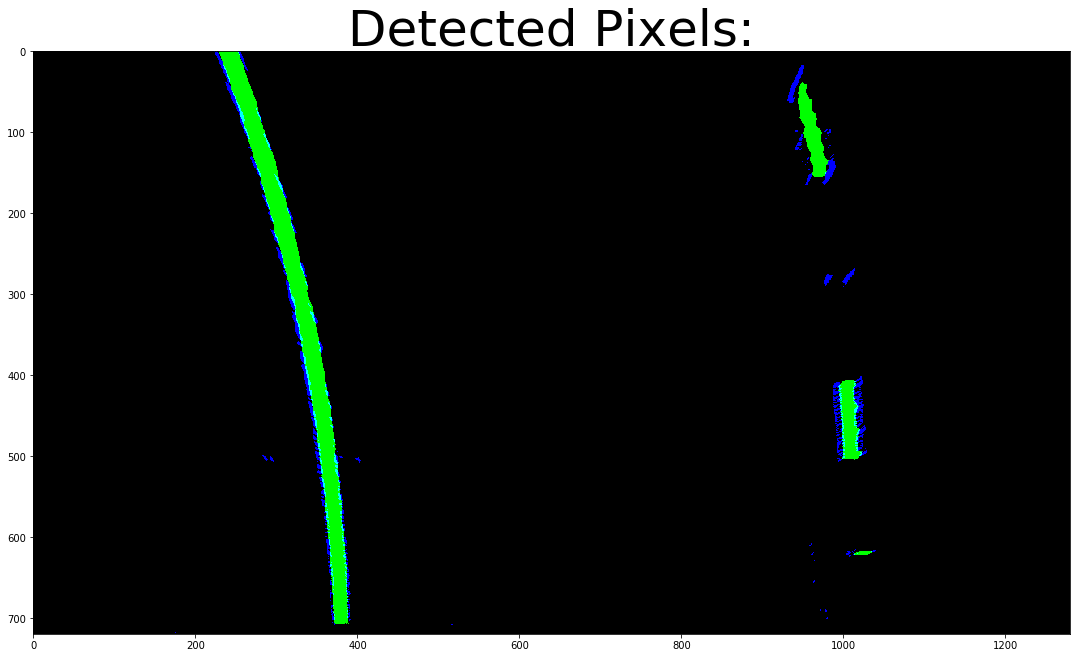

In [7]:
def sobel_HLS_filters(raw_img, mag_thresh=(30, 255), dir_thresh=(0.1, 0.7), s_thresh=(120, 255), l_thresh=(130, 255), white_thresh=(210, 255)):
    img = np.copy(raw_img)
    
    #convert to HLS color space and keep L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #Sobel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=5)
    
    #compute direction
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    #compute magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)#scale
    
    sobel_binary =  np.zeros_like(grad_dir)
    mag_cond = (grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1]) # magnitude condition
    dir_cond =  (grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1]) #direction condition
    sobel_binary[mag_cond & dir_cond] = 1

    #threshold S and L channels
    color_binary = np.zeros_like(s_channel)
    s_cond = ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) | (l_channel > white_thresh[0]) #special case for white lines (low S, but *very high* L)
    l_cond = (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])
    color_binary[s_cond & l_cond] = 1
    
    #stack color and sobel filtered channels
    stacked_binary = np.dstack(( np.zeros_like(sobel_binary), color_binary, sobel_binary))# * 255
    return stacked_binary


##For testing, disregard
image = perspective_warp(mpimg.imread('test_images/test2.jpg'), unwarped_pts= np.float32(
    [[585, 460],
    [203, 720],
    [1127, 720],
    [695, 460]]), 
    warped_pts= np.float32(
    [[320, 0],
    [320, 720],
    [960, 720],
    [960, 0]]))

new_img = sobel_HLS_filters(image)

f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(new_img)
ax1.set_title('Detected Pixels:', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Stage 4b: Helper functions for smoothing lane jitter

In [8]:
leftx_stack = np.ndarray([], dtype=np.int32)
lefty_stack = np.ndarray([], dtype=np.int32)
rightx_stack = np.ndarray([], dtype=np.int32)
righty_stack = np.ndarray([], dtype=np.int32)
left_ctr=np.array([], dtype=np.int32)
right_ctr=np.array([], dtype=np.int32)

def resetSmootherStacks(): #Stacks of activated pixels to smooth over; must be reset at beginning of each video
    #global leftx_stack, lefty_stack, rightx_stack, righty_stack, left_ctr, right_ctr
    leftx_stack = np.ndarray([], dtype=np.int32)
    lefty_stack = np.ndarray([], dtype=np.int32)
    rightx_stack = np.ndarray([], dtype=np.int32)
    righty_stack = np.ndarray([], dtype=np.int32)
    left_ctr=np.array([], dtype=np.int32)
    right_ctr=np.array([], dtype=np.int32)

In [9]:
def smoother(leftx, lefty, rightx, righty): #takes points and pushes onto a stack. Returns last three inputs.
    global leftx_stack, lefty_stack, rightx_stack, righty_stack, left_ctr, right_ctr
    #add to stack
    leftx_stack = np.append(leftx_stack, leftx)
    lefty_stack = np.append(lefty_stack, lefty)
    rightx_stack = np.append(rightx_stack, rightx)
    righty_stack = np.append(righty_stack, righty)
    
    #keep track of number of points added at each call
    left_ctr = np.append(left_ctr, len(leftx))
    right_ctr = np.append(right_ctr, len(rightx))
    
    if len(left_ctr)>3: #only store inputs from last 3 calls
        leftx_stack = np.delete(leftx_stack, np.s_[0:int(left_ctr[0])])
        lefty_stack = np.delete(lefty_stack, np.s_[0:int(left_ctr[0])])
        left_ctr = np.delete(left_ctr, 0)
    if len(right_ctr)>3:
        rightx_stack = np.delete(rightx_stack, np.s_[0:int(right_ctr[0])])
        righty_stack = np.delete(righty_stack, np.s_[0:int(right_ctr[0])])
        right_ctr = np.delete(right_ctr, 0)
    #return whole stack
    return leftx_stack.astype(int), lefty_stack.astype(int), rightx_stack.astype(int), righty_stack.astype(int)    

### Stage 4: Lane Finding

In [10]:
left_fit = None #declare in global scope to fix bug
right_fit = None

def find_lane(binary_warped):
    global left_fit, right_fit, left_ctr
    
    margin = 100 #margin for searching around last polynomials
    
    #get detected pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #search around last polynomial starting from 3rd frame
    if len(left_ctr)>3:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    else:
        #sliding window parameters
        nwindows = 9
        minpix = 100
        window_height = np.int(binary_warped.shape[0]//nwindows)
        
        #flatten color map of detected lines and get histogram of bottom half
        flattened = np.sum(binary_warped, axis=2)
        histogram = np.sum(flattened[flattened.shape[0]//2:,:], axis=0)

        out_img = binary_warped
        #starting point of lane lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            #compute window bounds
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            #get activated pixels in each window
            in_left_window = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            in_right_window = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(in_left_window)
            right_lane_inds.append(in_right_window)

            #recenter window if pixel number threshold met
            if len(in_left_window) > minpix:
                leftx_current = np.int(np.mean(nonzerox[in_left_window]))
            if len(in_right_window) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[in_right_window]))

        try: #hack-y fix
            #only append points in windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except:
            pass
    
    #get coordinates of all activated pixels
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #y values to plot for 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    #smooth out point detection over last 3 frames
    leftx, lefty, rightx, righty = smoother(leftx, lefty, rightx, righty)
    try:
        #fit polynomial to points
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except:
        #just in case a line was not found
        print("derp")
        left_fit = None
        right_fit = None
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    #mark activated points with colors (red--> left, blue-->right)
    #print(lefty.shape)
    out_img[lefty, leftx] = [1, 0, 0]
    out_img[righty, rightx] = [0, 0, 1]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    #make array of all points to draw polygon later
    poly_left = np.dstack((left_fitx, ploty))
    poly_right = np.dstack((right_fitx, ploty))
    poly_pts = np.array(np.concatenate((poly_left, np.flip(poly_right, axis = 1)), axis=0).reshape((-1,1,2)), np.int32)
    
    y_eval = np.max(ploty) #bottom of image
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #compute new polynomial based on points scaled to real world
    left_fit_true = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_true = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #calculate curvature with true polynomials
    left_curverad = ((1 + (2*left_fit_true[0]*y_eval*ym_per_pix + left_fit_true[1])**2)**1.5) / np.absolute(2*left_fit_true[0])
    right_curverad = ((1 + (2*right_fit_true[0]*y_eval*ym_per_pix + right_fit_true[1])**2)**1.5) / np.absolute(2*right_fit_true[0])    
    
    #car position in lane
    car_pos_px = midpoint - (rightx_base+leftx_base)/2 
    car_pos = round(car_pos_px*xm_per_pix, 2)
    
    return out_img, left_curverad, right_curverad, poly_pts, car_pos

## Full Pipeline

In [11]:
#Constants
unwarped_pts = np.float32(
    [[585, 460],
    [203, 720],
    [1127, 720],
    [695, 460]])

warped_pts = np.float32(
    [[320, 0],
    [320, 720],
    [960, 720],
    [960, 0]])

def main_pipeline(image):
    #1. undistort image
    undistorted = undistort_img(image)
    img_size = image.shape
    
    #2. warp using perspective transform
    warped = perspective_warp(undistorted, unwarped_pts, warped_pts)
    
    #3. apply color and sobel filters to find lane pixels
    filtered_binary = sobel_HLS_filters(warped)
    
    #4. find lanes and compute curve radius and car position in lane
    detected_lane_img, right_curve_rad, left_curve_rad, poly_pts, car_pos_m = find_lane(filtered_binary)
    
    #5. draw lane overlay using polygon points from step 4
    cv2.fillConvexPoly(detected_lane_img, poly_pts,(72,124,150))

    #6. unwarp overlay containing lines and lane
    unwarped_overlay = perspective_unwarp(detected_lane_img, warped_pts, unwarped_pts)
    
    #7. superimpose overlay over initial image to obtain composite image
    unwarped2 = unwarped_overlay.astype(dtype=np.uint8)
    composite = cv2.addWeighted(undistorted, 1., unwarped2, 1., 0.)
    
    #8. make labels
    Rleft = "Left line curvature: " + str(int(left_curve_rad)) + "m"
    Rright = "Right line curvature: " + str(int(right_curve_rad)) + "m"
    
    #sanity check for straight lanes (radius approaches inf, cap at 10km)
    if left_curve_rad > 10000:
        Rleft = "Left line curvature: >10km"
    if right_curve_rad > 10000:
        Rright = "Right line curvature: >10km"
    
    if car_pos_m <= 0:
        carPos = "Car lane position: left " + str(abs(car_pos_m)) + "m" 
    else:
        carPos = "Car lane position: right " + str(abs(car_pos_m)) + "m" 
    
    #9. draw labels on composite image
    cv2.putText(composite, Rleft, (100, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0))
    cv2.putText(composite, Rright, (700, 60), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0))
    cv2.putText(composite, carPos, (400, 145), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0))
    
    return composite
    

## Test 1: Main Project Video

In [17]:
#testing
image = mpimg.imread('test_images/test2.jpg')
new_img = main_pipeline(image)
resetSmootherStacks()

#don't do both at the same time--breaks the smoothing algo for some reason
showPlot = False
showVideo = True

#if an error is thrown, keep rerunning the cell until it works; there's some sort of dumb race condition in the kernel
if(showPlot):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(new_img)
    ax2.set_title('Final Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

if(showVideo):
    clip1 = VideoFileClip('project_video.mp4')#.subclip(0,5)
    clip_output = 'overlayed_video.mp4'
    clip = clip1.fl_image(main_pipeline)
    %time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video overlayed_video.mp4
[MoviePy] Writing video overlayed_video.mp4


100%|█████████▉| 1260/1261 [06:33<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: overlayed_video.mp4 

CPU times: user 4min 24s, sys: 1.59 s, total: 4min 25s
Wall time: 6min 36s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))